### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

### Model Training

13>15,12>6,8>3,15>10,12>1,15>5,13>14,2>13,0>7,7>9,9>8,11>4,10>0,0>12,14>11|4:2>13>14>11>4


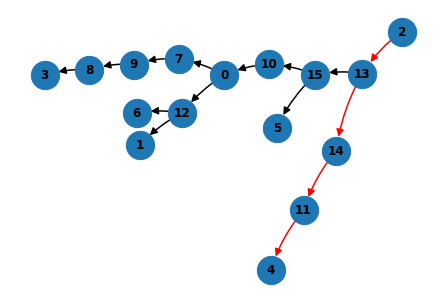

In [2]:
# You can generate an example tree using this function
ex = generate_example(16, 0)
print(ex)

# You can visualize an example using this function (as long as the tree is valid)
parse_example(ex)

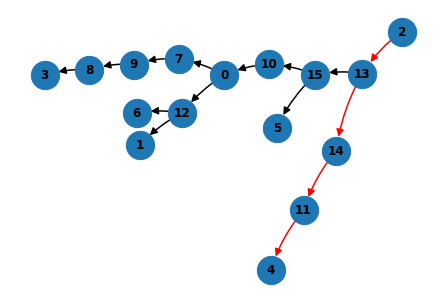

In [3]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [4]:
for tokens, masks in test_loader:
    for i in range(tokens.shape[0]):
        t = tokens[i]
        m = masks[i]
        print("Prompt:", dataset.untokenize(t[~m]))
        print("Completion:", dataset.untokenize(t[m]), end="\n\n")
    break

Prompt: 13>7,0>15,15>1,1>8,8>14,6>9,12>11,8>4,4>5,2>12,10>13,1>6,1>2,14>3,3>10|5:0
Completion: >15>1>8>4>5

Prompt: 10>5,2>13,1>14,14>9,10>11,13>1,4>12,9>15,6>10,2>4,7>3,3>2,9>6,15>8,7>0|11:7
Completion: >3>2>13>1>14>9>6>10>11

Prompt: 3>14,8>4,8>1,8>5,10>7,1>11,10>13,9>2,10>9,7>0,0>15,0>8,0>12,3>6,0>3|13:10
Completion: >13

Prompt: 12>8,8>10,6>9,7>13,11>0,1>6,2>1,0>14,9>12,8>11,4>2,9>15,9>5,10>7,10>3|3:4
Completion: >2>1>6>9>12>8>10>3

Prompt: 5>0,11>14,9>6,15>5,6>1,2>9,14>8,5>4,5>11,15>13,1>15,1>12,15>7,3>10,5>3|12:2
Completion: >9>6>1>12

Prompt: 10>11,10>15,3>13,8>4,12>3,15>5,8>0,15>9,11>7,14>1,7>6,4>2,8>12,12>10,15>14|0:8
Completion: >0

Prompt: 15>2,0>4,3>9,15>1,12>7,8>14,8>11,9>0,15>6,14>3,13>5,2>12,8>15,9>10,5>8|7:13
Completion: >5>8>15>2>12>7

Prompt: 12>15,11>5,1>13,10>3,4>2,0>14,2>9,8>1,14>4,14>12,0>7,12>8,14>6,8>10,6>11|13:0
Completion: >14>12>8>1>13

Prompt: 15>3,15>1,4>2,0>13,3>6,13>9,7>11,9>4,0>15,5>0,2>7,11>8,6>14,12>5,6>10|10:12
Completion: >5>0>15>3>6>10

Prompt: 3>0,

In [5]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [6]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model.pt")

In [7]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


0>9,0>1,5>11,10>7,6>0,6>5,6>10,6>8,3>15,14>6,12>3,13>14,13>12,4>13,2>4|9:2>4>13>14>6>0>9


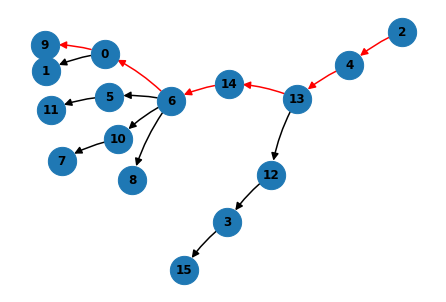

In [8]:
test_graph = generate_example(n_states, np.random.randint(400_000, 600_000), order="backward")
pred, correct = eval_model(model, dataset, test_graph)
if correct:
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)
print(pred)

In [9]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

### Experiment: Looking at Embeddings

In [10]:
embedding_matrix = model.W_E.detach().cpu().numpy()
embedding_matrix = embedding_matrix - embedding_matrix.mean(axis=-1, keepdims=True)

# Compute L2 norm for each row
row_norms = np.linalg.norm(embedding_matrix, axis=1, keepdims=True)
embedding_matrix = embedding_matrix / row_norms

incoming_embeddings = embedding_matrix[3:19]
outgoing_embeddings = embedding_matrix[19:]
all_nodes = embedding_matrix[3:]

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score

X = all_nodes
y = np.zeros((32,))
y[16:] = 1.0

probe = LinearRegression().fit(X, y)
# Calculate train loss
y_pred = probe.predict(X)
loss = mean_squared_error(y, y_pred)
loss

1.3222756223285614e-13

In [12]:
y_pred[:16]

array([5.9604645e-08, 2.9802322e-07, 7.1525574e-07, 5.9604645e-08,
       1.7881393e-07, 2.9802322e-07, 1.7881393e-07, 2.6822090e-07,
       2.3841858e-07, 2.3841858e-07, 3.5762787e-07, 3.8743019e-07,
       5.3644180e-07, 3.5762787e-07, 5.6624413e-07, 1.4901161e-07],
      dtype=float32)

In [13]:
probe

LinearRegression()

In [14]:
embedding_matrix.mean(axis=1)

array([-6.9849193e-10,  0.0000000e+00, -6.9849193e-10,  1.6298145e-09,
       -2.3283064e-10, -4.6566129e-10, -4.6566129e-10, -2.7939677e-09,
        1.3969839e-09, -1.6298145e-09, -1.8626451e-09, -1.3969839e-09,
        4.6566129e-10,  9.3132257e-10,  6.9849193e-10,  9.3132257e-10,
        3.0267984e-09,  0.0000000e+00, -2.0954758e-09,  1.8626451e-09,
        0.0000000e+00,  1.3969839e-09,  2.3283064e-10,  2.5611371e-09,
       -2.3283064e-09,  2.9103830e-09, -9.3132257e-10,  1.8626451e-09,
        0.0000000e+00,  0.0000000e+00, -1.2223609e-09,  4.6566129e-10,
       -6.9849193e-10, -4.6566129e-10, -9.3132257e-10], dtype=float32)

In [15]:
incoming_embeddings

array([[-0.05955783, -0.04651975, -0.0774742 , ...,  0.04724649,
         0.01560289,  0.23823978],
       [ 0.0007991 , -0.02041807,  0.1056877 , ..., -0.11498069,
         0.05794969, -0.15996033],
       [-0.00158451, -0.15038358, -0.05534289, ..., -0.07480281,
        -0.0103944 , -0.13729659],
       ...,
       [-0.05465658, -0.08668789,  0.00939552, ...,  0.09229839,
         0.00196997,  0.17450233],
       [-0.00762075,  0.05404986,  0.05568255, ...,  0.12652203,
         0.07268702,  0.01046259],
       [-0.01615055,  0.0133104 , -0.07818068, ...,  0.09386133,
         0.11359201, -0.09077817]], dtype=float32)

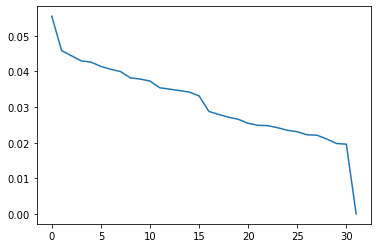

In [16]:
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(all_nodes)

explained_variance = pca.explained_variance_ratio_
plt.plot(explained_variance)

plt.show()

In [17]:
pca.explained_variance_

array([5.6174830e-02, 4.6398316e-02, 4.4956144e-02, 4.3476142e-02,
       4.3142240e-02, 4.1912436e-02, 4.1101836e-02, 4.0455479e-02,
       3.8655635e-02, 3.8324986e-02, 3.7755888e-02, 3.5837907e-02,
       3.5466801e-02, 3.5041120e-02, 3.4632459e-02, 3.3538975e-02,
       2.9120158e-02, 2.8272334e-02, 2.7490972e-02, 2.6884066e-02,
       2.5749750e-02, 2.5192598e-02, 2.5084808e-02, 2.4503822e-02,
       2.3758305e-02, 2.3356343e-02, 2.2492958e-02, 2.2375625e-02,
       2.1304838e-02, 2.0006489e-02, 1.9819580e-02, 1.0077001e-15],
      dtype=float32)

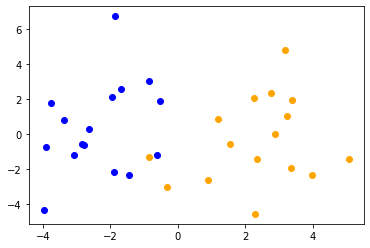

In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assume that 'data' is your original dataset
scaler = StandardScaler()
data_scaled = scaler.fit_transform(all_nodes)

pca = PCA(n_components=2)  # k is the desired number of components
data_transformed = pca.fit_transform(data_scaled)

fig, ax = plt.subplots()

plt.scatter(data_transformed[:16, 0], data_transformed[:16, 1], color="blue")
plt.scatter(data_transformed[16:, 0], data_transformed[16:, 1], color="orange")

In [19]:
dataset.idx2tokens[3]

'>10'

In [20]:
explained_variance = pca.explained_variance_ratio_

In [21]:
import numpy as np
from numpy.linalg import norm
for i in range(15):
    for j in range(i+1, 16):
        cosine = np.dot(incoming_embeddings[i],incoming_embeddings[j])
        print(cosine)
        

0.010733113
-0.035859913
-0.04851623
-0.027139299
0.026065078
-0.036517184
-0.02968574
0.0015938133
0.011567462
-0.006220471
0.021423599
-0.017528618
-0.014885161
-0.09355475
-0.07574723
0.007934473
-0.015638433
-0.04661727
-0.02358416
-0.00072617084
-0.033552825
-0.022245392
-0.04145173
-0.028152548
-0.058678687
-0.0016360581
-0.026160255
-0.015044879
-0.012557622
-0.020163482
-0.017806718
0.02747672
-0.018918967
0.00021377206
-0.005784098
-0.026490144
-0.023694582
-0.00047623366
-0.0019229697
-0.025444325
-0.008454906
-0.005837295
-0.006465273
-0.012742924
-0.013498247
-0.009131262
-0.07055436
-0.032597028
-0.06587714
-0.0790844
-0.01600769
-0.005649736
0.007432591
-0.03795532
-0.06496724
-0.076603964
-0.0019733086
-1.5817583e-05
-0.03580276
-0.039138727
-0.0117629655
-0.04154795
-0.0069329366
0.0036419556
-0.031579457
0.0027507283
-0.02332095
-0.039326727
-0.07588942
-0.051581804
-0.046554692
-0.005816293
0.0005082339
0.04184866
-0.01244567
-0.10989564
-0.048236832
-0.05701414
-0.02

### Experiment: Probing


In [22]:
X, graphs = aggregate_activations(
    model=model,
    dataset=dataset,
    activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
    n_states=n_states,
    n_samples=1_024
)

for key in X.keys():
   tensor_list = [ x[0, [i for i in range(45) if (i-1) % 3 == 0], 0] for x in X[key] ]
   X[key] = torch.cat(tensor_list, dim=0).detach().cpu().numpy()

In [23]:
from sklearn import preprocessing
y = {"incoming": [], "outgoing": []}

for graph in graphs:
    tokens = dataset.tokenize(graph)[:-1]
    labels = [dataset.idx2tokens[idx] for idx in tokens]
    y["outgoing"].append([labels[i-1] for i in range(45) if (i-1)%3 == 0])
    y["incoming"].append([labels[ i ] for i in range(45) if (i-1)%3 == 0])

y["incoming"] = preprocessing.LabelEncoder().fit_transform( np.array(y["incoming"]).flatten() )
y["outgoing"] = preprocessing.LabelEncoder().fit_transform( np.array(y["outgoing"]).flatten() )

In [24]:
for xkey in X.keys():    
    for ykey in y.keys():
        score = linear_probing(X[xkey], y[ykey])
        print(f"Layer {xkey.split('.')[1]} {ykey} node probe - {score:.3f}")

Layer 0 incoming node probe - 1.000
Layer 0 outgoing node probe - 0.084
Layer 1 incoming node probe - 1.000
Layer 1 outgoing node probe - 1.000
Layer 2 incoming node probe - 1.000
Layer 2 outgoing node probe - 1.000
Layer 3 incoming node probe - 1.000
Layer 3 outgoing node probe - 1.000
Layer 4 incoming node probe - 1.000
Layer 4 outgoing node probe - 1.000
Layer 5 incoming node probe - 1.000
Layer 5 outgoing node probe - 1.000


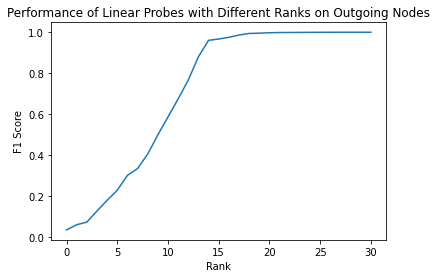

In [25]:
scores = []
for rank in range(1, 32):
    score = linear_probing(X[utils.get_act_name("v", 5, "attn")], y["outgoing"], rank=rank)
    scores.append(score)

plt.plot(scores)
plt.title("Performance of Linear Probes with Different Ranks on Outgoing Nodes")
plt.xlabel("Rank")
plt.ylabel("F1 Score")
plt.show()

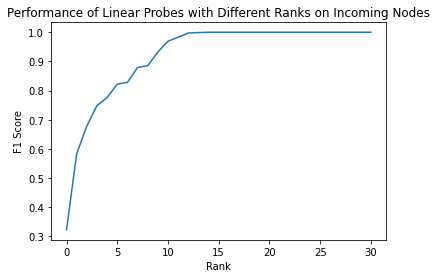

In [26]:
scores = []
for rank in range(1, 32):
    score = linear_probing(X[utils.get_act_name("v", 5, "attn")], y["incoming"], rank=rank)
    scores.append(score)

plt.plot(scores)
plt.title("Performance of Linear Probes with Different Ranks on Incoming Nodes")
plt.xlabel("Rank")
plt.ylabel("F1 Score")
plt.show()

### Experiment: Low Rank Approximation of Attention

In [27]:
from functools import partial


def add_low_rank_hook(layer, k):
    pca = PCA(n_components=k)  # k is the desired rank of the approximation
    pca = pca.fit(X[utils.get_act_name("v", layer, "attn")])

    # Add low-rank hook
    def low_rank_hook(
            resid_pre,
            hook,
            position):
        # Each HookPoint has a name attribute giving the name of the hook.
        np_resid = resid_pre[:, position, 0, :].detach().cpu().numpy()
        b, p, d = np_resid.shape
        low_rank = pca.transform(np_resid.reshape(b*p, d))
        inv_low_rank = pca.inverse_transform(low_rank).reshape(b, p, d)
        resid_pre[:, position, 0, :] = torch.from_numpy(inv_low_rank).cuda()
        return resid_pre

    temp_hook_fn = partial(low_rank_hook, position=[i for i in range(45) if (i-1) % 3 == 0])
    model.blocks[layer].attn.hook_v.add_hook(temp_hook_fn)

In [28]:
model.reset_hooks()
add_low_rank_hook(1, 16)
add_low_rank_hook(2, 16)
add_low_rank_hook(3, 16)
add_low_rank_hook(4, 16)
add_low_rank_hook(5, 16)

In [29]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.0000%
random: 100.0000%


### Experiment: Activation Patching

In [31]:
def generate_goal_distance_examples(distance):
    # Generate clean and corrupted prompts
    clean_prompt = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"
    edges = [f"{i}>{i+1}" for i in range(15 - distance - 1)] + [f"{15 - distance - 1}>{15 - distance}", f"{15 - distance - 1}>{15 - distance + 1}"] + [f"{i}>{i+1}" for i in range(15 - distance + 1, 15)]
    path = '>'.join([str(x) for x in range(16) if x != 15 - distance])
    corrupted_prompt = ",".join(edges) + "|" + f"{15}:{path}"
    return clean_prompt, corrupted_prompt


def goal_distance_activation_patching(distance):
    # Generate clean and corrupted prompts
    clean_prompt, corrupted_prompt = generate_goal_distance_examples(distance)
    parse_example(clean_prompt)
    plt.show()
    parse_example(corrupted_prompt)
    plt.show()
    # Tokenize
    clean_tokens = torch.from_numpy(dataset.tokenize(clean_prompt)[0:-1]).cuda()
    corrupted_tokens = torch.from_numpy(dataset.tokenize(corrupted_prompt)[0:-1]).cuda()
    patching_result = activation_patching(model, dataset, clean_tokens, corrupted_tokens, 46 + (15 - distance + 1) )
    return patching_result, clean_tokens

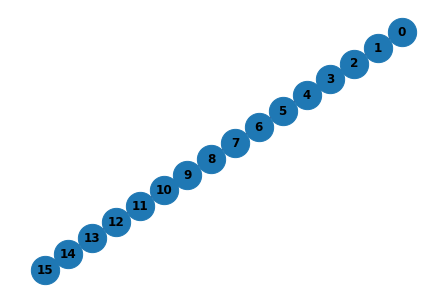

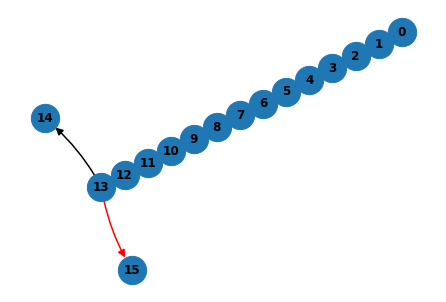

Clean logit difference: 28.632
Corrupted logit difference: -26.726
Positive Direction: >14
Negative Direction: >15


  0%|          | 0/6 [00:00<?, ?it/s]

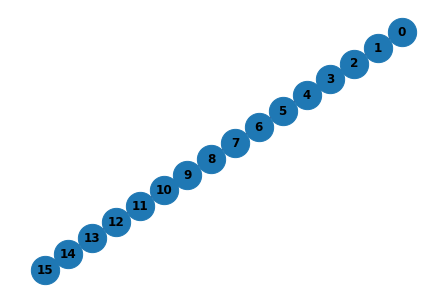

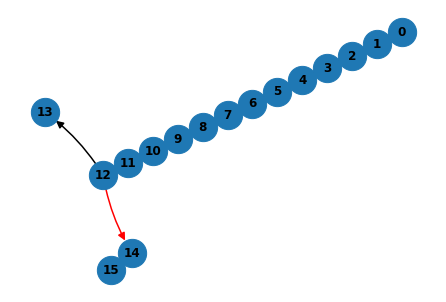

Clean logit difference: 20.599
Corrupted logit difference: -31.021
Positive Direction: >13
Negative Direction: >14


  0%|          | 0/6 [00:00<?, ?it/s]

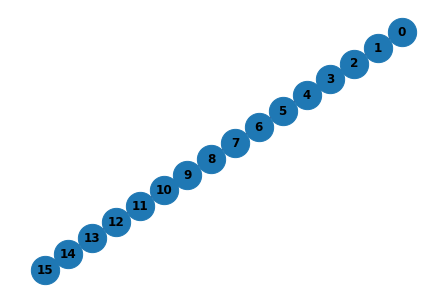

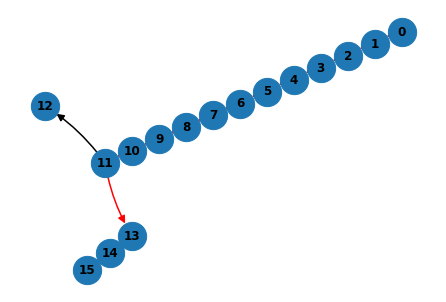

Clean logit difference: 30.959
Corrupted logit difference: -28.329
Positive Direction: >12
Negative Direction: >13


  0%|          | 0/6 [00:00<?, ?it/s]

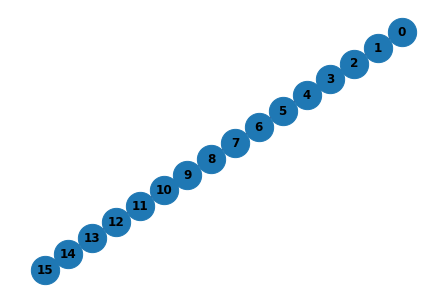

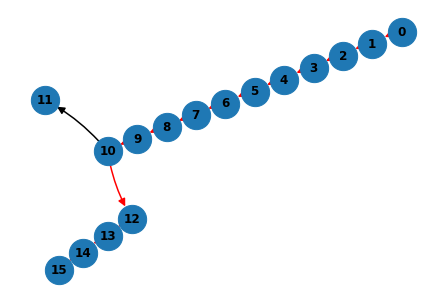

Clean logit difference: 28.172
Corrupted logit difference: -30.761
Positive Direction: >11
Negative Direction: >12


  0%|          | 0/6 [00:00<?, ?it/s]

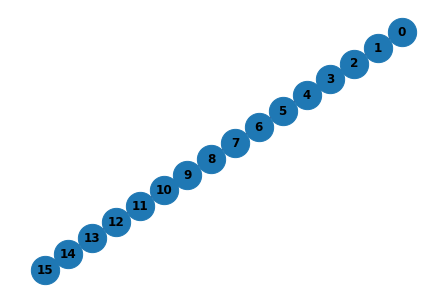

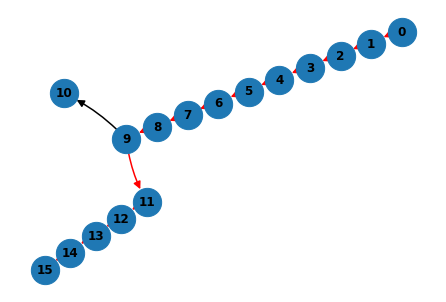

Clean logit difference: 27.548
Corrupted logit difference: -28.529
Positive Direction: >10
Negative Direction: >11


  0%|          | 0/6 [00:00<?, ?it/s]

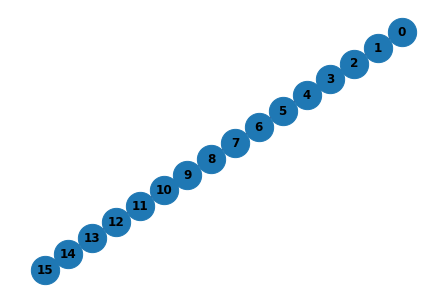

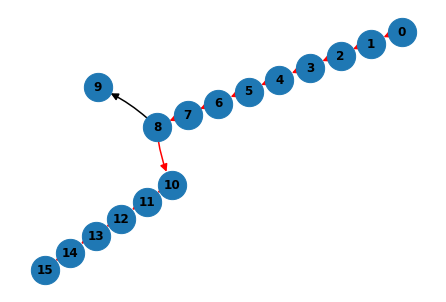

Clean logit difference: 24.128
Corrupted logit difference: -28.838
Positive Direction: >9
Negative Direction: >10


  0%|          | 0/6 [00:00<?, ?it/s]

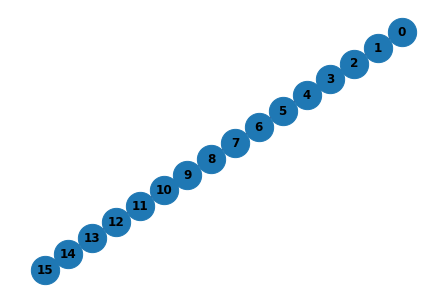

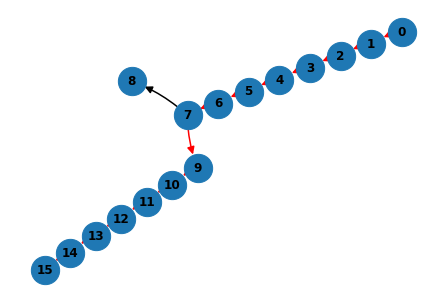

Clean logit difference: 27.738
Corrupted logit difference: -27.034
Positive Direction: >8
Negative Direction: >9


  0%|          | 0/6 [00:00<?, ?it/s]

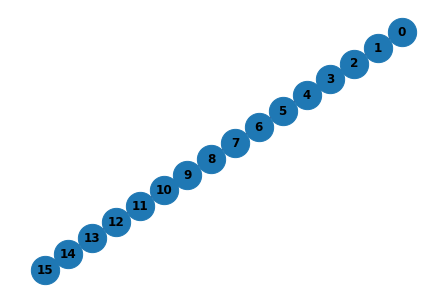

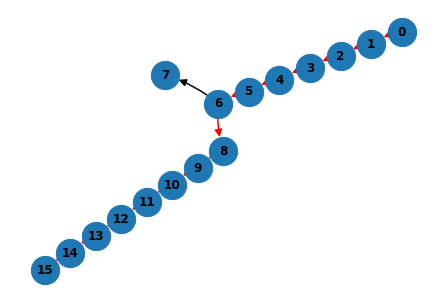

Clean logit difference: 28.092
Corrupted logit difference: -27.944
Positive Direction: >7
Negative Direction: >8


  0%|          | 0/6 [00:00<?, ?it/s]

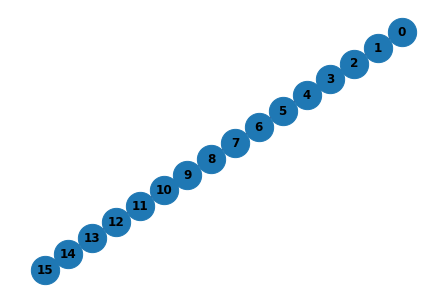

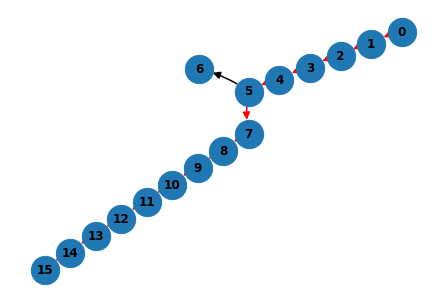

Clean logit difference: 26.328
Corrupted logit difference: -22.959
Positive Direction: >6
Negative Direction: >7


  0%|          | 0/6 [00:00<?, ?it/s]

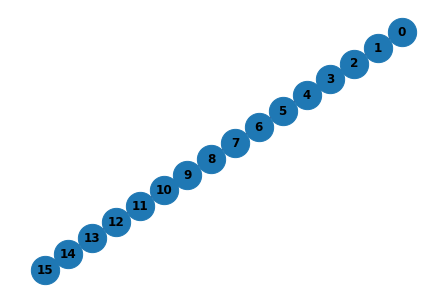

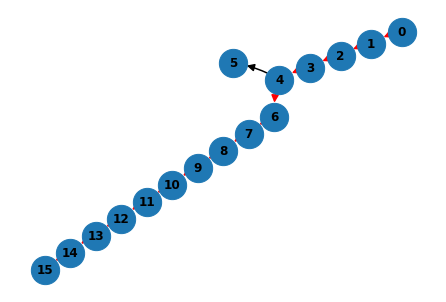

Clean logit difference: 23.962
Corrupted logit difference: -26.489
Positive Direction: >5
Negative Direction: >6


  0%|          | 0/6 [00:00<?, ?it/s]

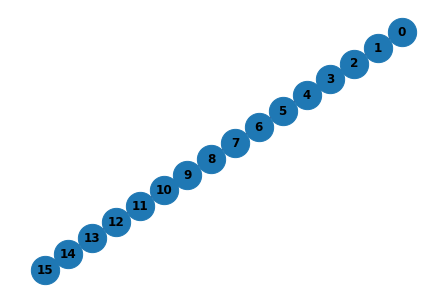

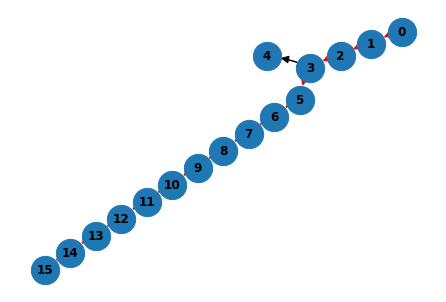

Clean logit difference: 28.749
Corrupted logit difference: -28.624
Positive Direction: >4
Negative Direction: >5


  0%|          | 0/6 [00:00<?, ?it/s]

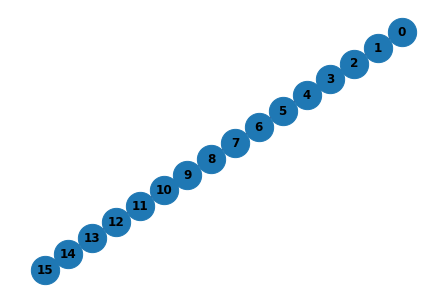

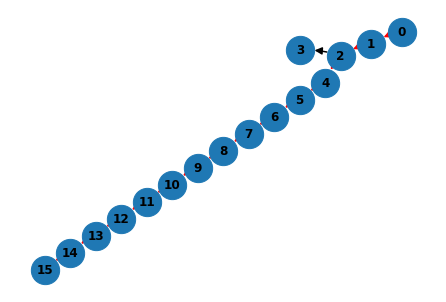

Clean logit difference: 23.565
Corrupted logit difference: -22.898
Positive Direction: >3
Negative Direction: >4


  0%|          | 0/6 [00:00<?, ?it/s]

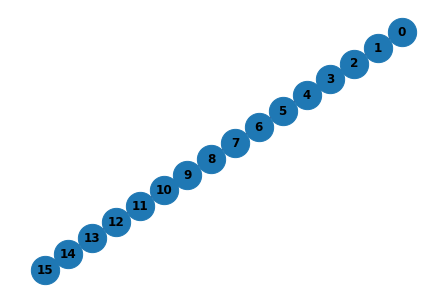

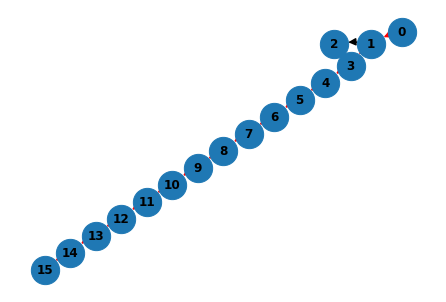

Clean logit difference: 21.542
Corrupted logit difference: -23.868
Positive Direction: >2
Negative Direction: >3


  0%|          | 0/6 [00:00<?, ?it/s]

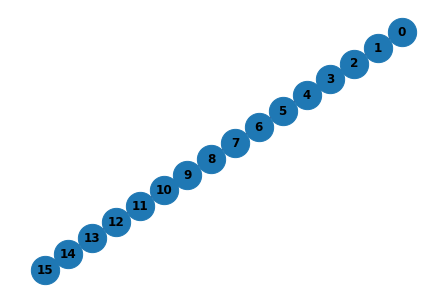

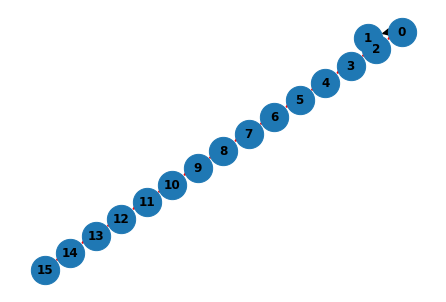

Clean logit difference: 19.914
Corrupted logit difference: -28.110
Positive Direction: >1
Negative Direction: >2


  0%|          | 0/6 [00:00<?, ?it/s]

In [32]:
model.reset_hooks()
patchings = [goal_distance_activation_patching(i) for i in range(1, 15)]

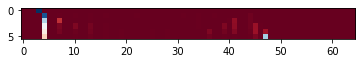

In [33]:
import matplotlib.animation as animation
from IPython.display import HTML

model.reset_hooks()
# Create a figure
fig = plt.figure()

# Function to update each frame
def update(i):
    plt.clf()
    plt.imshow(patchings[i][0].detach().cpu().numpy(), cmap='RdBu')

# Create animation

ani = animation.FuncAnimation(fig, update, frames=len(patchings), interval=200)
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, bitrate=1800)

# Save as mp4
ani.save('myAnimation.mp4', writer=writer)
HTML(ani.to_jshtml())


In [34]:
index = 6
%matplotlib inline
plot_activations(patchings[index][0], patchings[index][1], dataset)


In [35]:
patchings[index][0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0